# Load packages

In [1]:
# import modules
import os
from onto_vae.ontobj import *
from onto_vae.vae_model import *
import pickle
import sys
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from onto_vae.modules import Encoder, Decoder, OntoEncoder, OntoDecoder
from onto_vae.fast_data_loader import FastTensorDataLoader

# Load Ontology object

In [2]:
fp = open("../data/OntoVAE/GO_symbol_ontobj.pickle","rb+")
onto_obj=pickle.load(fp)

In [3]:
onto_obj.match_dataset(expr_data ='../data/OntoVAE/expr_vst_combat.csv',
                  name='immune_cell',
                  top_thresh=1000, 
                   bottom_thresh=30)

# OntoVAE model training

In [4]:
#!/usr/bin/env python3
###-------------------------------------------------------------###
##                  VAE WITH ONTOLOGY IN DECODER                 ##
###-------------------------------------------------------------###

class OntoVAE(nn.Module):
    """
    This class combines a normal encoder with an ontology structured decoder

    Parameters
    -------------
    ontobj: instance of the class Ontobj(), containing a preprocessed ontology and the training data
    dataset: which dataset to use for training
    top_thresh: top threshold to tell which trimmed ontology to use
    bottom_thresh: bottom_threshold to tell which trimmed ontology to use
    neuronnum: number of neurons per term
    drop: dropout rate, default is 0.2
    z_drop: dropout rate for latent space, default is 0.5
    """

    def __init__(self, ontobj, dataset, top_thresh=1000, bottom_thresh=30, neuronnum=3, drop=0.2, z_drop=0.5):
        super(OntoVAE, self).__init__()

        if not str(top_thresh) + '_' + str(bottom_thresh) in ontobj.genes.keys():
            sys.exit('Available trimming thresholds are: ' + ', '.join(list(ontobj.genes.keys())))

        self.ontology = ontobj.description
        self.top = top_thresh
        self.bottom = bottom_thresh
        self.genes = ontobj.genes[str(top_thresh) + '_' + str(bottom_thresh)]
        self.in_features = len(self.genes)
        self.mask_list = ontobj.masks[str(top_thresh) + '_' + str(bottom_thresh)]
        self.mask_list = [torch.tensor(m, dtype=torch.float32) for m in self.mask_list]
        self.layer_dims_dec =  np.array([self.mask_list[0].shape[1]] + [m.shape[0] for m in self.mask_list])
        self.latent_dim = self.layer_dims_dec[0] * neuronnum
        self.layer_dims_enc = [self.latent_dim]
        self.neuronnum = neuronnum
        self.drop = drop
        self.z_drop = z_drop
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Encoder
        self.encoder = Encoder(self.in_features,
                                self.latent_dim,
                                self.layer_dims_enc,
                                self.drop,
                                self.z_drop)

        # Decoder
        self.decoder = OntoDecoder(self.in_features,
                                    self.layer_dims_dec,
                                    self.mask_list,
                                    self.latent_dim,
                                    self.neuronnum,
                                    self.drop)
        
        if not dataset in ontobj.data[str(top_thresh) + '_' + str(bottom_thresh)].keys():
            sys.exit('Available datasets are: ' + ', '.join(list(ontobj.data[str(top_thresh) + '_' + str(bottom_thresh)].keys())))

        self.X = ontobj.data[str(top_thresh) + '_' + str(bottom_thresh)][dataset]

    def reparameterize(self, mu, log_var):
        """
        Parameters
        -------------
        mu: mean from the encoder's latent space
        log_var: log variance from the encoder's latent space
        """
        sigma = torch.exp(0.5*log_var) 
        eps = torch.randn_like(sigma) 
        return mu + eps * sigma
        
    def get_embedding(self, x):
        mu, log_var = self.encoder(x)
        # embedding = mu
        embedding =  self.reparameterize(mu, log_var)
        return embedding

    def forward(self, x):
        # encoding
        mu, log_var = self.encoder(x)
            
        # sample from latent space
        # z = mu
        z = self.reparameterize(mu, log_var)
        
        # decoding
        reconstruction = self.decoder(z)
            
        return reconstruction, mu, log_var

    def vae_loss(self, reconstruction, mu, log_var, data, kl_coeff):
        kl_loss = -0.5 * torch.sum(1. + log_var - mu.pow(2) - log_var.exp(), )
        rec_loss = F.mse_loss(reconstruction, data, reduction="sum")
        return torch.mean(rec_loss + kl_coeff*kl_loss)

    def train_round(self, dataloader, lr, kl_coeff, optimizer):
        """
        Parameters
        -------------
        dataloader: pytorch dataloader instance with training data
        lr: learning rate
        kl_coeff: coefficient for weighting Kullback-Leibler loss
        optimizer: optimizer for training
        """
        # set to train mode
        self.train()

        # initialize running loss
        running_loss = 0.0

        # iterate over dataloader for training
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):

            # move batch to device
            data = data[0].to(self.device)
            optimizer.zero_grad()

            # forward step
            reconstruction, mu, log_var = self.forward(data)
            loss = self.vae_loss(reconstruction, mu, log_var, data, kl_coeff)
            # running_loss += loss.item()
            # running_loss = loss.item()
            if i == 0 :
                running_loss_min=loss.item()
            elif running_loss_min > loss.item() :
                    running_loss_min=loss.item()


            # backward propagation
            loss.backward()

            # zero out gradients from non-existent connections
            for i in range(len(self.decoder.decoder)):
                self.decoder.decoder[i][0].weight.grad = torch.mul(self.decoder.decoder[i][0].weight.grad, self.decoder.masks[i])

            # perform optimizer step
            optimizer.step()

            # make weights in Onto module positive
            for i in range(len(self.decoder.decoder)):
                self.decoder.decoder[i][0].weight.data = self.decoder.decoder[i][0].weight.data.clamp(0)

        # compute avg training loss
        # train_loss = running_loss/len(dataloader)
        train_loss = running_loss_min
        return train_loss

    def val_round(self, dataloader, kl_coeff):
        """
        Parameters
        -------------
        dataloader: pytorch dataloader instance with training data
        kl_coeff: coefficient for weighting Kullback-Leibler loss
        """
        # set to eval mode
        self.eval()

        # initialize running loss
        running_loss = 0.0

        with torch.no_grad():
            # iterate over dataloader for validation
            for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):

                # move batch to device
                data = data[0].to(self.device)

                # forward step
                reconstruction, mu, log_var = self.forward(data)
                loss = self.vae_loss(reconstruction, mu, log_var,data, kl_coeff)
                # running_loss += loss.item()
                if i == 0 :
                    running_loss_min=loss.item()
                elif running_loss_min > loss.item() :
                        running_loss_min=loss.item()

        # compute avg val loss
        # val_loss = running_loss/len(dataloader)
        val_loss = running_loss_min
        return val_loss

    def train_model(self, modelpath, lr=1e-4, kl_coeff=1e-4, batch_size=128, epochs=300, log=True, log_location="", **kwargs):
        """
        Parameters
        -------------
        modelpath: where to store the best model (full path with filename)
        lr: learning rate
        kl_coeff: Kullback Leibler loss coefficient
        batch_size: size of minibatches
        epochs: over how many epochs to train
        log: whether run should be logged to neptune
        **kwargs: pass the run here if log == True
        """
        # train-test split
        indices = np.random.RandomState(seed=42).permutation(self.X.shape[0])
        X_train_ind = indices[:round(len(indices)*0.8)]
        X_val_ind = indices[round(len(indices)*0.8):]
        X_train, X_val = self.X[X_train_ind,:], self.X[X_val_ind,:]

        # convert train and val into torch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        X_val = torch.tensor(X_val, dtype=torch.float32)

        # generate dataloaders
        trainloader = FastTensorDataLoader(X_train, 
                                       batch_size=batch_size, 
                                       shuffle=True)
        valloader = FastTensorDataLoader(X_val, 
                                        batch_size=batch_size, 
                                        shuffle=False)

        val_loss_min = float('inf')
        optimizer = optim.AdamW(self.parameters(), lr = lr)

        for epoch in range(epochs):
            print(f"Epoch {epoch+1} of {epochs}")
            train_epoch_loss = self.train_round(trainloader, lr, kl_coeff, optimizer)
            val_epoch_loss = self.val_round(valloader, kl_coeff)
            
            if log == True:
                progress = "Epoch: {0}, Train Loss: {1:.4f}, Val Loss: {2:.4f}".format(epoch+1, train_epoch_loss, val_epoch_loss)
                with open(log_location, "a") as logs:
                    logs.write(progress+"\n")
            
            # if ((epoch+1) in [5,10,20] or (epoch+1) %50 == 0):
            #     new_modelpath=modelpath+"_model_epoch_"+str(epoch+1)+".pt"
            #     print('save model:'+ modelpath)
            #     torch.save({
            #         'epoch': epoch,
            #         'model_state_dict': self.state_dict(),
            #         'optimizer_state_dict': optimizer.state_dict(),
            #         'loss': val_epoch_loss,
            #     }, new_modelpath)
                
            if ((val_epoch_loss < val_loss_min) and (epoch+1)>=280):
                new_modelpath=modelpath+"_best_model.pt"
                print('New best model!')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_epoch_loss,
                }, new_modelpath)
                val_loss_min = val_epoch_loss
                
            print(f"Train Loss: {train_epoch_loss:.4f}")
            print(f"Val Loss: {val_epoch_loss:.4f}")


    def _pass_data(self, data, output):
        """
        output
            one of 'act': pathway activities
                    'rec': reconstructed values
        """

        # set to eval mode
        self.eval()

        # get latent space embedding
        with torch.no_grad():
            z = self.get_embedding(data)
            z = z.to('cpu').detach().numpy()
        
        z = np.array(np.split(z, z.shape[1]/self.neuronnum, axis=1)).mean(axis=2).T

        # get activities from decoder
        activation = {}
        def get_activation(index):
            def hook(model, input, output):
                activation[index] = output.to('cpu').detach()
            return hook

        hooks = {}

        for i in range(len(self.decoder.decoder)-1):
            key = str(i)
            value = self.decoder.decoder[i][0].register_forward_hook(get_activation(i))
            hooks[key] = value
        
        with torch.no_grad():
            reconstruction, _, _ = self.forward(data)

        act = torch.cat(list(activation.values()), dim=1).numpy()
        act = np.array(np.split(act, act.shape[1]/self.neuronnum, axis=1)).mean(axis=2).T
        
        # remove hooks
        for h in hooks:
            hooks[h].remove()

        # return pathway activities or reconstructed gene values
        if output == 'act':
            return np.hstack((z,act))
        if output == 'rec':
            return reconstruction.to('cpu').detach().numpy()
        

    def get_pathway_activities(self, ontobj, dataset, **kwargs):
        """
        Parameters
        -------------
        ontobj: instance of the class Ontobj(), should be the same as the one used for model training
        dataset: which dataset to use for pathway activity retrieval
        **kwargs
        terms: if we only want to get back the activities for certain terms (should be list of ids)
        """
        if self.ontology != ontobj.description:
            sys.exit('Wrong ontology provided, should be ' + self.ontology)

        data = ontobj.data[str(self.top) + '_' + str(self.bottom)][dataset].copy()

        # convert data to tensor and move to device
        data = torch.tensor(data, dtype=torch.float32).to(self.device)

        # retireve pathway activities
        act = self._pass_data(data, 'act')

        # if term was specified, subset
        if 'terms' in kwargs:
            terms = kwargs.get('terms')
            annot = ontobj.annot[str(self.top) + '_' + str(self.bottom)]
            term_ind = annot[annot.ID.isin(terms)].index.to_numpy()

            act = act[:,term_ind]

        return act


    def get_reconstructed_values(self, ontobj, dataset, **kwargs):
        """
        Parameters
        -------------
        ontobj: instance of the class Ontobj(), should be the same as the one used for model training
        dataset: which dataset to use for pathway activity retrieval

        **kwargs
        rec_genes: if we only want to get back values for certain genes
        """
        if self.ontology != ontobj.description:
            sys.exit('Wrong ontology provided, should be ' + self.ontology)

        data = ontobj.data[str(self.top) + '_' + str(self.bottom)][dataset].copy()

        # convert data to tensor and move to device
        data = torch.tensor(data, dtype=torch.float32).to(self.device)

        # retrieve pathway activities
        rec = self._pass_data(data, 'rec')

        # if genes were passed, subset
        if 'rec_genes' in kwargs:
            genes = kwargs.get('rec_genes')
            onto_genes = ontobj.genes[str(self.top) + '_' + str(self.bottom)]
            gene_ind = np.array([onto_genes.index(g) for g in genes])

            rec = rec[:,gene_ind]

        return rec

        
    def perturbation(self, ontobj, dataset, genes, values, output='terms', **kwargs):
        """
        This function retrieves pathway activities after performing in silico perturbation

        Parameters
        -------------
        ontobj: instance of the class Ontobj(), should be the same as the one used for model training
        dataset: which dataset to use for perturbation and pathway activity retrieval
        genes: a list of genes to perturb
        values: list with new values, same length as genes
        output: 'terms' or 'genes'

        **kwargs
        terms: if we only want to get back the activities for certain terms (should be list of ids)
        rec_genes: if we only want to get back values for certain reconstructed genes
        """

        if self.ontology != ontobj.description:
            sys.exit('Wrong ontology provided, should be ' + self.ontology)

        data = ontobj.data[str(self.top) + '_' + str(self.bottom)][dataset].copy()

        # get indices of the genes in list
        indices = [self.genes.index(g) for g in genes]

        # replace their values
        for i in range(len(genes)):
            data[:,indices[i]] = values[i]

        # convert data to tensor and move to device
        data = torch.tensor(data, dtype=torch.float32).to(self.device)

        # get pathway activities or reconstructed values after perturbation
        if output == 'terms':
            res = self._pass_data(data, 'act')
        if output == 'genes':
            res = self._pass_data(data, 'rec')

        # if term was specified, subset
        if 'terms' in kwargs:
            terms = kwargs.get('terms')
            annot = ontobj.annot[str(self.top) + '_' + str(self.bottom)]
            term_ind = annot[annot.ID.isin(terms)].index.to_numpy()

            res = res[:,term_ind]
        
        if 'rec_genes' in kwargs:
            genes = kwargs.get('rec_genes')
            onto_genes = ontobj.genes[str(self.top) + '_' + str(self.bottom)]
            gene_ind = np.array([onto_genes.index(g) for g in genes])

            res = res[:,gene_ind]

        return res



In [5]:
pwo_model = OntoVAE(ontobj=onto_obj,              # the Ontobj we will use
                    dataset='immune_cell',     # which dataset from the Ontobj to use for model training
                    top_thresh=1000,         # which trimmed version to use
                    bottom_thresh=30,
                    neuronnum=3)        # which trimmed version to use     
pwo_model.to(pwo_model.device) 

/mnt/raid61/Personal_data/hezhifeng/software/miniconda3/envs/ontovae/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


OntoVAE(
  (encoder): Encoder(
    (encoder): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=19469, out_features=1755, bias=True)
        (1): BatchNorm1d(1755, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout(p=0.2, inplace=False)
        (3): ReLU()
      )
    )
    (mu): Sequential(
      (0): Linear(in_features=1755, out_features=1755, bias=True)
      (1): Dropout(p=0.5, inplace=False)
    )
    (logvar): Sequential(
      (0): Linear(in_features=1755, out_features=1755, bias=True)
      (1): Dropout(p=0.5, inplace=False)
    )
  )
  (decoder): OntoDecoder(
    (decoder): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=1755, out_features=42, bias=True)
      )
      (1): Sequential(
        (0): Linear(in_features=1797, out_features=213, bias=True)
      )
      (2): Sequential(
        (0): Linear(in_features=2010, out_features=621, bias=True)
      )
      (3): Sequential(
        (0): Linear(in_features

In [ ]:
#training model
pwo_model.train_model('../data/OntoVAE',   # where to store the best model
                     lr=1e-4,                                 # the learning rate
                     kl_coeff=1e-4,                           # the weighting coefficient for the Kullback Leibler loss
                     batch_size=128,                          # the size of the minibatches
                     epochs=300,
                     log=True,
                     log_location="./immune_cell_HC_GO_loss_log.csv")

# Model performance

In [6]:
# load saved model
checkpoint = torch.load('../data/OntoVAE/model.pt',  ## Path/to/the/model.pt
                        map_location = torch.device(pwo_model.device))
pwo_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
# retrieve pathway activities
pwo_act = pwo_model.get_pathway_activities(ontobj=onto_obj,
                                           dataset='immune_cell')

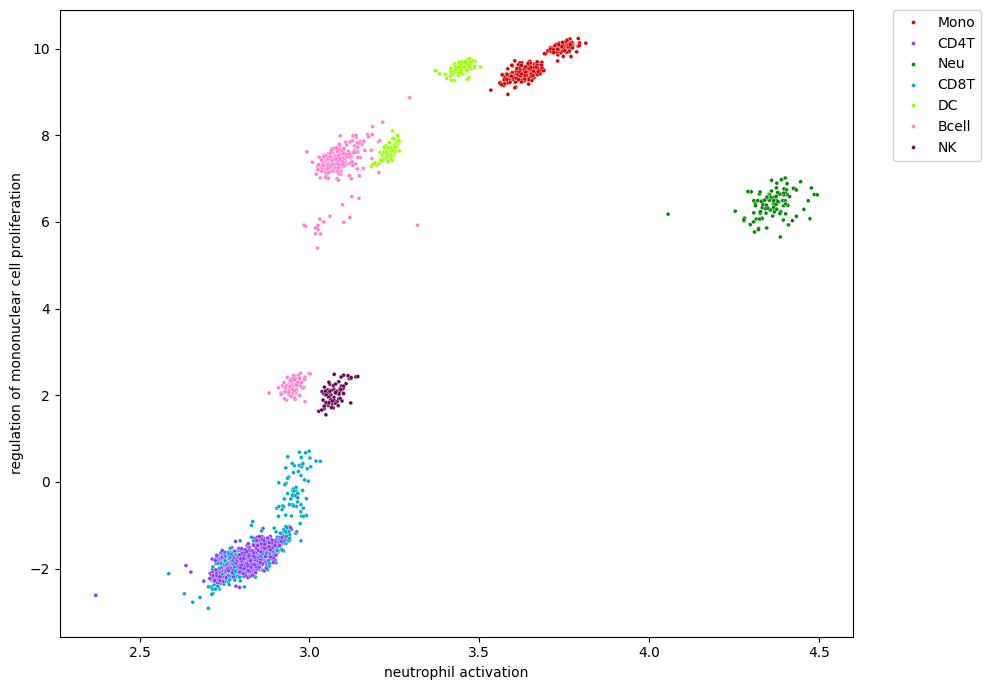

In [8]:
# make scatterplot for two pathway activities
onto_obj.plot_scatter(sample_annot = '../data/OntoVAE/annot.csv',   # pandas Dataframe or path to annotation file
                 color_by = 'celltype2',                                 # variable to use for coloring
                 act = pwo_act,                                          # pathway activities computed from OntoVAE model
                 term1 = 'neutrophil activation',        # term on x-axis of scatter plot
                 term2 = 'regulation of mononuclear cell proliferation',            # term on y-axis of scatter plot
                 top_thresh = 1000,                                      # which trimmed version to use
                 bottom_thresh = 30) 

# In silico knockout

In [9]:
def perturbation(self, ontobj, dataset, genes, values, tissue=None , annot= None ,output='terms', terms=None, rec_genes=None):
        """
        Retrieves pathway activities or reconstructed gene values after performing in silico perturbation.

        Parameters
        ----------
        ontobj
            instance of the class Ontobj(), should be the same as the one used for model training
        dataset
            which dataset to use for perturbation and pathway activity retrieval
        genes
            a list of genes to perturb
        values
            list with new values, same length as genes
        output
            - 'terms': retrieve pathway activities
            - 'genes': retrieve reconstructed values

        terms
            list of ontology term ids whose values should be retrieved
        rec_genes
            list of genes whose values should be retrieved
        """

        if self.ontology != ontobj.description:
            raise ValueError('Wrong ontology provided, should be ' + self.ontology)

        data = ontobj.data[str(self.top) + '_' + str(self.bottom)][dataset].copy()

        # get indices of the genes in list
        indices = [self.genes.index(g) for g in genes]

        # replace their values
        if tissue is not None:
             anno=pd.read_csv(annot)
             for i in range(len(genes)):
                data[anno[anno['celltype']==tissue].index,indices[i]] = values[i]
                # data[anno[anno['celltype2'].isin(tissue)].index,indices[i]] = values[i]
        else :
             for i in range(len(genes)):
                 data[:,indices[i]] = values[i]     
        

        # convert data to tensor and move to device
        data = torch.tensor(data, dtype=torch.float32).to(self.device)

        # get pathway activities or reconstructed values after perturbation
        if output == 'terms':
            res = self._pass_data(data, 'act')
        if output == 'genes':
            res = self._pass_data(data, 'rec')

        # if term was specified, subset
        if terms is not None:
            annot = ontobj.annot[str(self.top) + '_' + str(self.bottom)]
            term_ind = annot[annot.ID.isin(terms)].index.to_numpy()

            res = res[:,term_ind]
        
        if rec_genes is not None:
            onto_genes = ontobj.genes[str(self.top) + '_' + str(self.bottom)]
            gene_ind = np.array([onto_genes.index(g) for g in rec_genes])

            res = res[:,gene_ind]

        return res

def wilcox_test(obj, control, perturbed, tissue=None , annot= None, direction='up', option='terms', top_thresh=1000, bottom_thresh=30):
        """ 
        Performs paired Wilcoxon test between activities and perturbed activities.

        Parameters
        ----------
        act
            numpy 2D array of pathway activities 
        perturbed_act
            numpy 2D array of perturbed pathway activities
        direction
            up: higher in perturbed
            down: lower in perturbed
        top_thresh
            top threshold for trimming
        bottom_thresh
            bottom_threshold for trimming
        option
            'terms' or 'genes'
        """
        # perform paired wilcoxon test over all terms
        if direction == 'up':
                alternative = 'greater' 
        elif direction == 'down':
                 alternative = 'less' 
        elif direction == 'twoside':
                 alternative = 'two-sided' 
        if tissue is not None:
            anno=pd.read_csv(annot)
            ti=anno[anno['celltype']==tissue].index
            # ti=anno[anno['celltype2'].isin(tissue)].index
            wilcox = [stats.wilcoxon(perturbed[ti,i], control[ti,i], zero_method='zsplit', alternative=alternative) for i in range(control.shape[1])]
        else :           
            wilcox = [stats.wilcoxon(perturbed[:,i], control[:,i], zero_method='zsplit', alternative=alternative) for i in range(control.shape[1])]
        stat = np.array([i[0] for i in wilcox])
        pvals = np.array([i[1] for i in wilcox])
        qvals = fdrcorrection(np.array(pvals))

        if option == 'terms':
            # extract ontology annot
            onto_annot = obj.extract_annot(top_thresh=top_thresh, bottom_thresh=bottom_thresh)

            # create results dataframe 
            res = pd.DataFrame({'id': onto_annot.ID.tolist(),
                                'term': onto_annot.Name.tolist(),
                                'depth': onto_annot.depth.tolist(),
                                'stat': stat,
                                'pval' : pvals,
                                'qval': qvals[1]})
        
        else:
            # extract ontology genes
            onto_genes = obj.extract_genes(top_thresh=top_thresh, bottom_thresh=bottom_thresh)

            # create results dataframe
            res = pd.DataFrame({'gene': onto_genes,
                                'stat': stat,
                                'pval' : pvals,
                                'qval': qvals[1]})

        res = res.sort_values('pval').reset_index(drop=True)
        return(res)

In [ ]:
names = []
with open('../data/OntoVAE/gene_list.txt', 'r') as file: #give the gene list you want to knockout one by one
    for i, line in enumerate(file):
        names.append(line.strip()) 
for gene in names[:]: 
    if gene not in onto_obj.genes['1000_30']:
        names.remove(gene)
torch.manual_seed(7567)
pwo_act = pwo_model.get_pathway_activities(ontobj=onto_obj,
                                           dataset='immune_cell')
for gene in names:
    pwo_ko_act=perturbation(pwo_model,ontobj=onto_obj,
                                dataset='immune_cell',
                                genes=[gene],
                                tissue="Neu",
                                annot='../data/OntoVAE/annot.csv',
                                values=[0])
    results_down = wilcox_test(    obj=onto_obj,
                    control = pwo_act,
                    perturbed = pwo_ko_act,
                    direction = 'down',
                    tissue="Neu",
                    annot='../data/OntoVAE/annot.csv',
                    top_thresh=1000,
                    bottom_thresh=30)
    results_down['gene']=gene
    results_down.to_csv("./knockout_results.csv",mode="a",index=False,header=False)